* The code here finds structural changes in given time series data and constructs plots + data to evaluate the detected significant trend changes. 
* The data is total prescriptions, by month, for a large number of generic drugs sold by competing manufacturers
* This notebook served as proof part of the proof of concept for this project. This was automated, along with a much larger code base for database management, feature engineering/extraction, modeling, evaluation, and report generation which served a production dashboard was built out as a result

In [1]:
# import modules

import os
import sys
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates
import glob
import re
import statsmodels as stm
import datetime

# Import R packages
import warnings
%load_ext rpy2.ipython

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.vectors import IntVector
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)
pandas2ri.activate()

In [2]:
# Set pandas preferences 
pd.options.display.max_columns=500
pd.options.display.max_colwidth=500

In [3]:
# Set plot options
sns.set()

In [4]:
# Bring the R functions we'll need into the python namespace
strucchange = importr('strucchange')
ts = robjects.r['ts']
as_yearmon = robjects.r['as.yearmon']

In [5]:
# The R function which will run the change point discovery algorithm
rstring = """ 
function(data_, start_date, h){
    ts_data = ts(data_, start=as.yearmon(start_date), freq=12)
    bp_data <- breakpoints(ts_data ~ 1, h=h)
    ci_data <- confint(bp_data)
    break_dates_mat <- breakdates(confint(bp_data), format.times=TRUE)
    break_dates_df <- as.data.frame(break_dates_mat)
    return_list <- list("break_dates_df" = break_dates_df, "fitted_bp_data" = fitted(bp_data), "confint_bp_data" = confint(bp_data), "ts_data" = ts_data)
    return(return_list)
}
"""

In [6]:
# Register the custom R function with the python namespace
changepoint_detector = robjects.r(rstring)

In [7]:
def plot_results(df, pd_from_r_df, title, figsize=(20,10)):
    fig = plt.figure(figsize=figsize)
    ax = df['T_Rx'].plot(x_compat=True)
    df['fitted_values'].plot(color='purple', alpha=0.5)
    break_points_list = pd.to_datetime(pd_from_r_df['breakpoints'].values).tolist()
    for break_point in break_points_list:
        local_slope = df.loc[break_point].local_slope_1
        if local_slope >= 0:
            colour = 'red'
        else:
            colour = 'green'
        if break_points_list.index(break_point) == 0:
            plt.axvline(x=break_point, color=colour, linestyle='--', linewidth=2, label='break points')
        else:
            plt.axvline(x=break_point, color=colour, linestyle='--', linewidth=2)
    confidence_list = list(zip(pd_from_r_df['lower_bound'].values, pd_from_r_df['upper_bound'].values))
    for tup in confidence_list:
        if confidence_list.index(tup) == 0:
            plt.axvspan(tup[0], tup[1], alpha=0.5, color='yellow', ymax=0.05, label='confidence intervals')
        else:
            plt.axvspan(tup[0], tup[1], alpha=0.5, color='yellow', ymax=0.05)
    plt.title(title, fontsize=18)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Total Rx', fontsize=18)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    save_name = title.replace(' ', '_') + '.png'
    plt.savefig(save_name)
    
    return break_points_list

In [8]:
def plot_failure(df, title, figsize=(20,10)):
    fig = plt.figure(figsize=figsize)
    ax = df['T_Rx'].plot(x_compat=True)
    plt.title(title, fontsize=18)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Total Rx', fontsize=18)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    save_name = title.replace(' ', '_') + '.png'
    plt.savefig(save_name)

In [9]:
def build_classes(change_value, local_slope):
    if change_value == 0:
        return "no"
    elif change_value == 1 and local_slope >=0:
        return "increase"
    elif change_value == 1 and local_slope < 0:
        return "decrease"

In [10]:
def run_detection_and_target_creation(df, title):
    
    # Define an R vector to pass to the change point function
    rdata = IntVector(df['T_Rx'].values.tolist())
    start_date = df.index.min()
    start_date = start_date.strftime("%Y-%m-%d")
    stop_h = False
    max_h = df.shape[0] // 2
    i = 2
    while not stop_h:
        try:
            print("testing h value: {0}".format(i))
            returned_values = changepoint_detector(rdata, start_date, h=i)
            stop_h = True
        except rpy2.rinterface_lib.embedded.RRuntimeError:
            print("this value of h = {0} did not find anything".format(i))
            i += 1
            if i > max_h:
                return None
    
    r_df = returned_values[0]
    fitted_bp_data = returned_values[1]
    
    with localconverter(robjects.default_converter + pandas2ri.converter):
        pd_from_r_df = robjects.conversion.rpy2py(r_df)
    
    # Fix the R dataframe
    pd_from_r_df.columns = ['lower_bound', 'breakpoints', 'upper_bound']
    pd_from_r_df['lower_bound'] = pd_from_r_df['lower_bound'].apply(lambda x: pd.to_datetime(x, format="%Y(%m)"))
    pd_from_r_df['upper_bound'] = pd_from_r_df['upper_bound'].apply(lambda x: pd.to_datetime(x, format="%Y(%m)"))
    pd_from_r_df['breakpoints'] = pd_from_r_df['breakpoints'].apply(lambda x: pd.to_datetime(x, format="%Y(%m)"))

    # Add the fitted values
    df['fitted_values'] = fitted_bp_data
    # Compute the local slope of the fitted values.  They are smoother and more likely to indicate the direction of change
    df['local_slope_1'] = df['fitted_values'].diff(periods=-1) / df['index'].diff(periods=-1)
    df['local_slope_1'].fillna(0, inplace=True)
    
    # Make the plot
    break_points_list = plot_results(df, pd_from_r_df, title)
    
    # Build the targets
    target_values = []
    for date_ in df.index.tolist():
        if date_ in break_points_list:
            target_values.append(1)
        else:
            target_values.append(0)
    
    df['change_next_month'] = target_values
    df['change_next_2_months'] = df['change_next_month'].shift(periods=-1, fill_value=0)
    df['change_next_3_months'] = df['change_next_month'].shift(periods=-2, fill_value=0)
    df['significant_change_next_month'] = df.apply(lambda row: build_classes(change_value=row['change_next_month'], local_slope=row['local_slope_1']), axis=1)
    df['significant_change_next_2_month'] = df['significant_change_next_month'].shift(periods=-1, fill_value="no")
    df['significant_change_next_3_month'] = df['significant_change_next_month'].shift(periods=-2, fill_value="no")

    return df

## Load data

In [16]:
df = pd.read_csv('example_data_cleaned.csv.gz', compression='gzip')

In [17]:
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))

In [19]:
man_ = df['Manufacture Updated'].unique()[0]
mol_ = df['Molecule Updated'].unique()[0]

R[write to console]: Error in if (any(obj$confint < 1) | any(obj$confint > obj$nobs)) warning(paste("Confidence intervals outside data time interval\n\t from ",  : 
  missing value where TRUE/FALSE needed

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In confint.breakpointsfull(bp_data) :
R[write to console]: 
 
R[write to console]:  Confidence interval 3 cannot be computed: P(argmax V <= 0) = 0.984

R[write to console]: 2: 
R[write to console]: In confint.breakpointsfull(bp_data) :
R[write to console]: 
 
R[write to console]:  Confidence interval 3 cannot be computed: P(argmax V <= 0) = 0.984



testing h value: 2
this value of h = 2 did not find anything
testing h value: 3


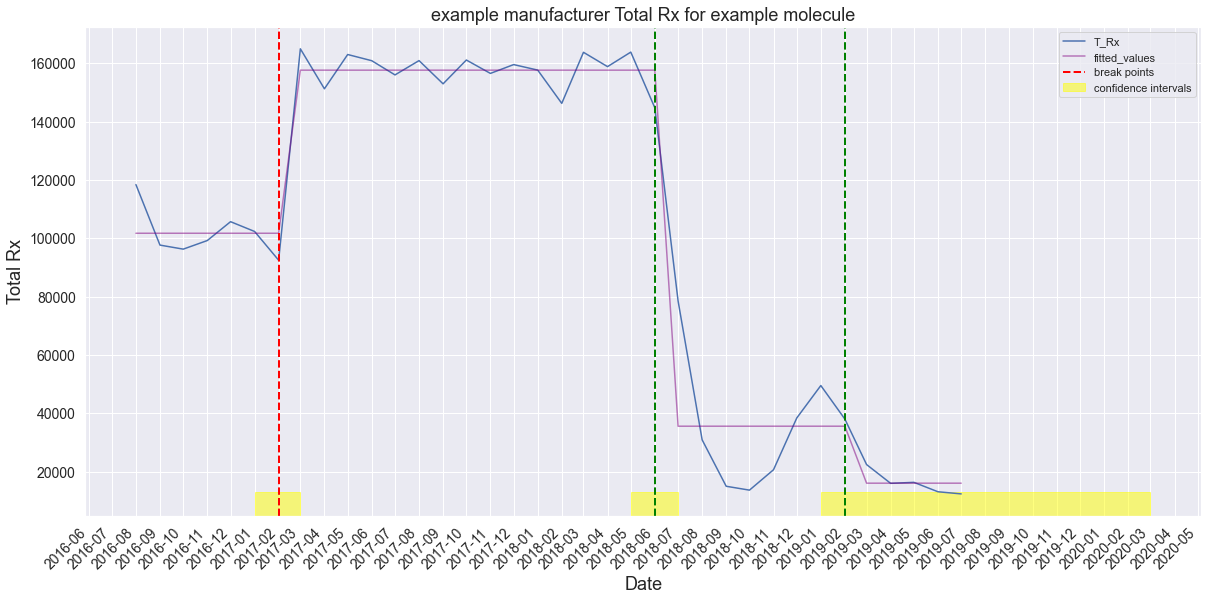

In [20]:
title = "{0} Total Rx for {1}".format(man_.lower(), mol_.lower())
df.reset_index(inplace=True, drop=True)
df.reset_index(inplace=True)
df.set_index('date', inplace=True)
df.columns = ['index', 'molecule', 'manufacturer', 'T_Rx']
df_results = run_detection_and_target_creation(df, title)
if df_results is None:
    print('No structural changes found for {0} - {1}'.format(man_.lower(), mol_.lower()))
    print('Plotting time series for inspection')
    plot_failure(df, title)